# Perform final calculations for dynamic (2D) fitting approaches
## Load group results

In [1]:
import pandas as pd
from pathlib import Path
base_output = Path('group_results')

group_res = {}
group_f = {}

for fp in base_output.rglob('group_stats.csv'):
    group_res[fp.parent.stem] = pd.read_csv(
        fp,
        index_col=0,
        header=[0])
    group_f[fp.parent.stem] = pd.read_csv(
        fp.parent / 'group_fstats.csv',
        index_col=0,
        header=[0])
    
combined_res = {key: pd.concat((group_res[key].loc[:, ['COPE', 'VARCOPE', 'z']] , group_f[key]), axis=1) for key in group_res}


In [11]:
def print_percentage_activations_all(all_df):
    out = {}
    for key, df in all_df.items():
        mean_activation_df = df.filter(regex='mean_activation', axis=0)
        mean_activation_df.index = mean_activation_df.index.str.replace('_mean_activation','').str.replace('conc_','')
        mean_activation_df = mean_activation_df.drop(['NAA', 'NAAG', 'Cr', 'PCr', 'PCh', 'GPC'])
        mean_activation_df

        constant_df = df.filter(regex='constant', axis=0)
        constant_df.index = constant_df.index.str.replace('_constant','').str.replace('conc_','')
        constant_df = constant_df.drop(['NAA', 'NAAG', 'Cr', 'PCr', 'PCh', 'GPC'])
        constant_df.COPE

        mean_activation_df
        # constant_df
        mean_activation_df.loc[:, ['COPE', 'VARCOPE']] = mean_activation_df.loc[:, ['COPE', 'VARCOPE']].div(constant_df.COPE, axis=0)
        out[key] = mean_activation_df.loc[:, ['COPE', 'z', 'f-stat', 'zf-stat','p']]
    
    out = pd.concat(out.values(), axis=1, keys=out.keys())

    formatter_dict = {}
    p_list = []
    for key in all_df:
        formatter_dict.update({
            (key, 'COPE'): "{:+0.1%}",
            #(key, 'VARCOPE'): "{:+0.2%}",
            (key, 'z'): "{:+0.2f}",
            (key, 'f-stat'): "{:+0.2f}",
            (key, 'zf-stat'): "{:+0.2f}",
            (key, 'p'): "{:0.1e}"})
        p_list.append((key, 'p'))
    return out.style\
    .format(formatter=formatter_dict)\
    .highlight_between(subset=p_list,left=0, right=0.05, props='font-weight:bold;color:#e83e8c')

print_percentage_activations_all(combined_res)

### Look at the linewidth terms

The ground truth value is 1.0. The correct model is fixed to this, th exact model tries to estimate the value from data, and the fixed has the wrong (constant) model

In [21]:
import numpy as np
for key in group_res:
    scaled_lw = group_res[key].filter(regex=r'gamma', axis=0).loc[:,'COPE'].div(np.pi).to_numpy()[0]
    print(f'{key}: {scaled_lw:0.3f}')

3T_correct_lb: 1.000
7T_correct_lb: 1.000
3T_fixed_lb: 0.210
7T_fixed_lb: 0.296
3T_exact_lb: 1.249
7T_exact_lb: 0.932


## Load the individual results
Store just the SD and Mean of the individual COPES

In [22]:
indiv_summary_res = {key: [] for key in group_res}

for fp in base_output.rglob('dyn_results.csv'):
    indiv_summary_res[fp.parent.parent.stem].append(
        pd.read_csv(
            fp,
            index_col=0,
            header=[0]))
    
for key in indiv_summary_res:
    tmp = pd.concat(indiv_summary_res[key])
    indiv_summary_res[key] =pd.concat((tmp.mean(), tmp.std()), axis=1, keys=['mean', 'sd'])

## Merge the two dataframes

Take the mean and SD from each

In [29]:
merged_df = {}
for key in group_res:
    merged_df[key] = pd.concat((
            group_res[key].loc[:,['COPE', 'VARCOPE']],
            indiv_summary_res[key]),
        axis=1)
    merged_df[key].loc[:,'SDCOPE'] = merged_df[key].loc[:,'VARCOPE'].pow(0.5)
    merged_df[key].drop(axis=1, labels=['VARCOPE',], inplace=True)
    merged_df[key].rename(
        columns={
            'COPE': 'GroupMean',
            'SDCOPE': 'GroupSD',
            'mean': 'IndivMean',
            'sd': 'IndivSD',
        },
        inplace=True)
    merged_df[key].sort_index(axis=1, inplace=True)
merged_df[key]

,GroupMean,GroupSD,IndivMean,IndivSD
conc_Ala_STIM0,-0.000255,0.000111,-0.000256,0.000582
conc_Ala_STIM1,-0.000256,0.000110,-0.000255,0.000610
conc_Ala_constant,0.000199,0.000056,0.000201,0.000299
conc_Asc_STIM0,-0.000040,0.000077,-0.000041,0.000607
conc_Asc_STIM1,-0.000037,0.000077,-0.000037,0.000668
...,...,...,...,...
conc_sIns_mean_activation,-0.000023,0.000012,-0.000023,0.000103
conc_NAA+NAAG_mean_activation,0.000575,0.000035,0.000575,0.000413
conc_Cr+PCr_mean_activation,0.000277,0.000025,0.000275,0.000353
conc_PCh+GPC_mean_activation,0.000039,0.000011,0.000039,0.000096


## Cohen's d

In [30]:
to_drop = ['NAA', 'NAAG', 'Cr', 'PCr', 'PCh', 'GPC', 'Ala', 'Gly', 'Lip09', 'Lip13a', 'Lip13b', 'Lip20', 'MM09', 'MM20', 'MM12', 'MM14', 'MM17']

def calc_cohens_d(all_df):
    out = {}
    for key, df in all_df.items():
        mean_activation_df = df.filter(regex='mean_activation', axis=0)
        mean_activation_df.index = mean_activation_df.index.str.replace('_mean_activation','').str.replace('conc_','')
        mean_activation_df = mean_activation_df.drop(to_drop)
        
        # Calculate Cohens d
        mean_activation_df.loc[:,'Cohens_d'] = mean_activation_df.GroupMean.div(mean_activation_df.IndivSD)

        constant_df = df.filter(regex='constant', axis=0)
        constant_df.index = constant_df.index.str.replace('_constant','').str.replace('conc_','')
        constant_df = constant_df.drop(to_drop)

        mean_activation_df.loc[:, ['GroupMean', 'GroupSD', 'IndivMean', 'IndivSD']] = \
              mean_activation_df.loc[:, ['GroupMean', 'GroupSD', 'IndivMean', 'IndivSD']].div(constant_df.GroupMean, axis=0)
        out[key] = mean_activation_df.loc[:, ['GroupMean', 'IndivSD', 'Cohens_d']]
        out[key].rename(
        columns={
            'GroupMean': 'Mean',
            'IndivSD': 'SD'},
        inplace=True)
    
    return pd.concat(out.values(), axis=1, keys=out.keys())

def print_cohensd_all(all_df):
    formatter_dict = {}
    for key in results_df.columns.get_level_values(0).unique():
        formatter_dict.update({
            (key, 'Mean'): "{:+0.1%}",
            (key, 'SD'): "{:0.3%}",
            (key, 'Cohens_d'): "{:0.3f}"})

    return all_df.style\
        .format(formatter=formatter_dict)

results_df = calc_cohens_d(merged_df)

print_cohensd_all(results_df)

In [31]:
to_plot_cd = results_df.loc[:,(slice(None), ['Cohens_d', 'Mean'])]
to_plot_cd = to_plot_cd.melt(ignore_index=False).reset_index(names=['Metabolite'])

#  Split into field strength and model
to_plot_cd[['Field', 'Model', 'tmp']] = to_plot_cd.variable_0.str.split('_', expand=True)
to_plot_cd = to_plot_cd.drop(['variable_0', 'tmp'], axis=1)
to_plot_cd = to_plot_cd.rename(columns = {'variable_1':'value_type'})

# Abs for Cohen's d and percentage for COPE
cd_index = to_plot_cd.value_type=="Cohens_d"
to_plot_cd.loc[cd_index, "value"] = to_plot_cd.loc[cd_index, "value"].abs()
to_plot_cd.loc[~cd_index, "value"] = to_plot_cd.loc[~cd_index, "value"] * 100.0
to_plot_cd

,Metabolite,value_type,value,Field,Model
0,Asc,Cohens_d,0.041211,3T,correct
1,Asp,Cohens_d,0.655537,3T,correct
2,GABA,Cohens_d,0.286843,3T,correct
3,GSH,Cohens_d,0.018043,3T,correct
4,Glc,Cohens_d,0.195201,3T,correct
...,...,...,...,...,...
187,sIns,Mean,-0.386115,7T,exact
188,NAA+NAAG,Mean,0.194364,7T,exact
189,Cr+PCr,Mean,0.164094,7T,exact
190,PCh+GPC,Mean,0.187707,7T,exact


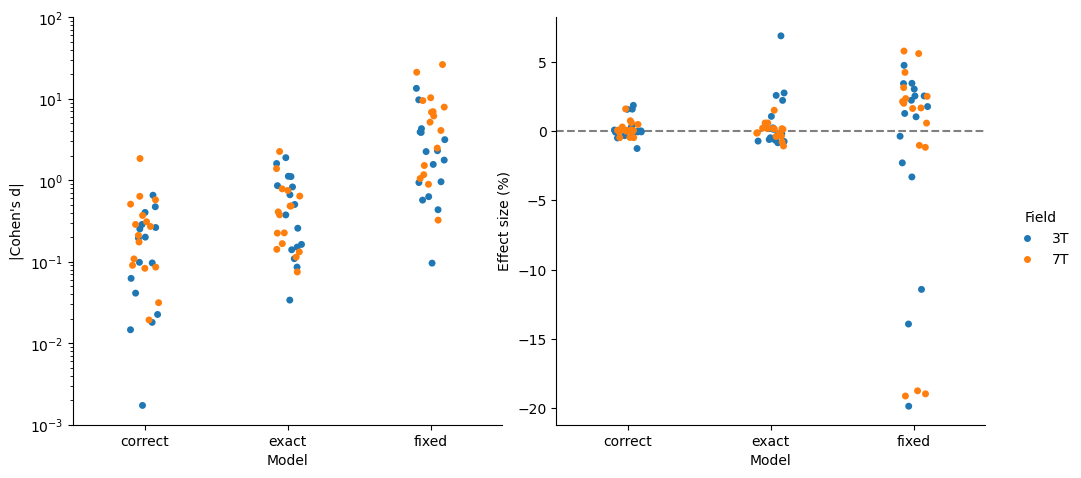

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt


effect_plot=sns.catplot(
    data=to_plot_cd,
    kind='strip',
    x='Model',
    hue='Field',
    y="value",
    log_scale=False,
    col="value_type",
    sharey=False,
    order=['correct', 'exact', 'fixed']
)
effect_plot.refline(y=0)
_ = effect_plot.axes.flat[0].set(yscale="log")
_ = effect_plot.axes.flat[1].set(ylabel="Effect size (%)")
_ = effect_plot.axes.flat[0].set(ylabel="|Cohen's d|")
_ = effect_plot.axes.flat[0].set(title="")
_ = effect_plot.axes.flat[1].set(title="")
_ = effect_plot.axes.flat[0].set_ylim([1E-3, 1E2])

effect_plot.savefig("figures/dynamic_effect_size.png", dpi=600, bbox_inches="tight") 

## Plot selected metabolites
This mimics the final formatting using R code

In [90]:
to_plot_cd2 = results_df.loc[:,(slice(None), ['Cohens_d', 'Mean', 'SD'])]
to_plot_cd2 = to_plot_cd2.melt(ignore_index=False).reset_index(names=['Metabolite'])

#  Split into field strength and model
to_plot_cd2[['Field', 'Model', 'tmp']] = to_plot_cd2.variable_0.str.split('_', expand=True)
to_plot_cd2 = to_plot_cd2.drop(['variable_0', 'tmp'], axis=1)
to_plot_cd2 = to_plot_cd2.rename(columns = {'variable_1':'value_type'})

# percentage for Mean/SD
cd_index = to_plot_cd2.value_type=="Cohens_d"
to_plot_cd2.loc[cd_index, "value"] = to_plot_cd2.loc[cd_index, "value"].abs()
to_plot_cd2.loc[~cd_index, "value"] = to_plot_cd2.loc[~cd_index, "value"] * 100.0

for (plus, t) in zip(['NAA+NAAG', 'Cr+PCr', 'PCh+GPC', 'Glu+Gln'], ['tNAA', 'tCr', 'tCho', 'Glx']):
    met_index = to_plot_cd2.Metabolite==plus
    to_plot_cd2.loc[met_index, "Metabolite"] = t

to_plot_cd2.to_csv('figures/dynamic_fitting_results.csv')

to_plot_cd2

,Metabolite,value_type,value,Field,Model
0,Asc,Cohens_d,0.041211,3T,correct
1,Asp,Cohens_d,0.655537,3T,correct
2,GABA,Cohens_d,0.286843,3T,correct
3,GSH,Cohens_d,0.018043,3T,correct
4,Glc,Cohens_d,0.195201,3T,correct
...,...,...,...,...,...
283,sIns,SD,1.718995,7T,exact
284,tNAA,SD,0.139752,7T,exact
285,tCr,SD,0.209095,7T,exact
286,tCho,SD,0.458551,7T,exact


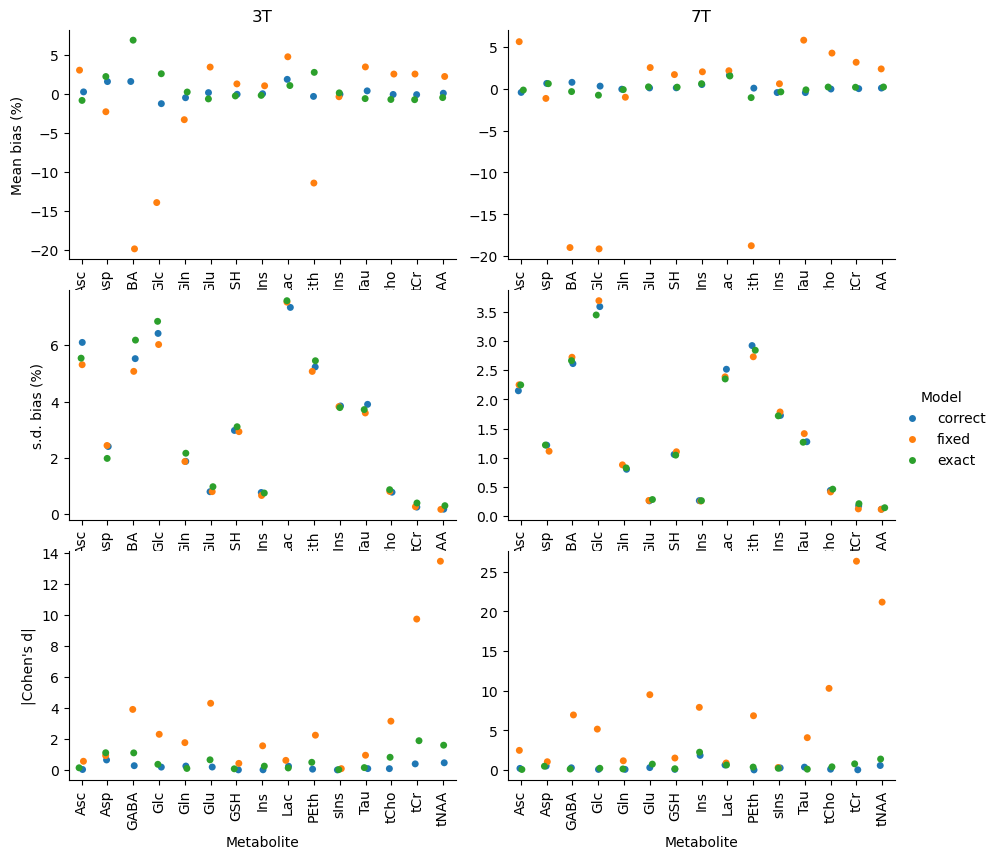

In [88]:
effect_plot2 = sns.catplot(
    data=to_plot_cd2,
    kind='strip',
    x='Metabolite',
    hue='Model',
    y="value",
    col="Field",
    row="value_type",
    col_order=['3T', '7T'],
    row_order=['Mean', 'SD', 'Cohens_d'],
    sharey=False,
    sharex=False,
    hue_order=['correct', 'fixed', 'exact'],
    order=[
        'Asc',
        'Asp',
        'GABA',
        'Glc',
        'Gln',
        'Glu',
        'GSH',
        'Ins',
        'Lac',
        'PEth',
        'sIns',
        'Tau',
        'tCho',
        'tCr',
        'tNAA']
)
_=effect_plot2.set_xticklabels(rotation=90)
effect_plot2.figure.set_size_inches(10,8)

_ = effect_plot2.axes.flat[0].set(ylabel="Mean bias (%)")
_ = effect_plot2.axes.flat[2].set(ylabel="s.d. bias (%)")
_ = effect_plot2.axes.flat[4].set(ylabel="|Cohen's d|")

for ax in effect_plot2.axes.flat[2:]:
    ax.set(title="")
_ = effect_plot2.axes.flat[0].set(title="3T")
_ = effect_plot2.axes.flat[1].set(title="7T")

effect_plot2.savefig("figures/dynamic_effect_size_per_met.png", dpi=600, bbox_inches="tight") 